In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import *

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [5]:
train_images=np.reshape(train_images, (-1,28,28,1))
test_images=np.reshape(test_images, (-1,28,28,1))

In [6]:
train_images = Concatenate()([train_images,train_images,train_images])
test_images = Concatenate()([test_images,test_images,test_images])

In [7]:
train_images.shape

TensorShape([60000, 28, 28, 3])

In [8]:
resized_train_images = tf.image.resize(train_images, (32,32))
resized_test_images = tf.image.resize(test_images, (32,32))

In [9]:
resized_train_images.shape, train_images.shape

(TensorShape([60000, 32, 32, 3]), TensorShape([60000, 28, 28, 3]))

In [10]:
from keras.preprocessing.image import img_to_array
train_X = np.asarray([img_to_array(im) for im in resized_train_images])
test_X = np.asarray([img_to_array(im) for im in resized_test_images])

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(train_X,
                                                           train_labels,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [12]:


# x_val = resized_train_images[50000:]
# x_train = resized_train_images[:50000]

# y_val = train_labels[50000:]
# y_train = train_labels[:50000]



In [13]:
train_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_generator = ImageDataGenerator(
    rescale=1./255
)

In [14]:
train_generator.fit(x_train)
test_generator.fit(x_val)

In [15]:
train_generator = train_generator.flow(x_train,y_train,batch_size=200)
test_generator = test_generator.flow(x_val,y_val,batch_size=200)

In [16]:
# original_dim = (32, 32, 3)
# target_size = (64, 64)
# input = keras.layers.Input(original_dim)
# x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, target_size))(input)

In [17]:
test_images.shape

TensorShape([10000, 28, 28, 3])

In [18]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [19]:
# conv_base.trainable = False





conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
from keras import models
from keras import layers


original_dim = (32, 32, 3)
target_size = (150, 150)


model = models.Sequential()
model.add(layers.Input(original_dim))
model.add(layers.Lambda(lambda image: tf.image.resize(image, target_size)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [22]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])

# history = model.fit_generator(
#       train_generator.flow(x_train,y_train,batch_size=100),
#       steps_per_epoch=500,
#       epochs=100,
#       validation_data=test_generator.flow(x_val,y_val,batch_size=100),
#       validation_steps=20)

In [23]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='best_weights.hdf5',verbose=1, save_best_only= True)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(1e-4),
              metrics=['acc'])

history = model.fit(train_generator,
                    epochs=25,
                    steps_per_epoch=240,
                    validation_data=test_generator,
                    validation_steps=60,
                    shuffle=True,
                    callbacks=[checkpointer])

Epoch 1/25
240/240 [==============================] - ETA: 0s - loss: 0.9463 - acc: 0.6496
Epoch 00001: val_loss improved from inf to 0.47533, saving model to best_weights.hdf5
240/240 [==============================] - 207s 861ms/step - loss: 0.9463 - acc: 0.6496 - val_loss: 0.4753 - val_acc: 0.8133
Epoch 2/25
240/240 [==============================] - ETA: 0s - loss: 0.4925 - acc: 0.8173
Epoch 00002: val_loss improved from 0.47533 to 0.37265, saving model to best_weights.hdf5
240/240 [==============================] - 210s 873ms/step - loss: 0.4925 - acc: 0.8173 - val_loss: 0.3726 - val_acc: 0.8601
Epoch 3/25
240/240 [==============================] - ETA: 0s - loss: 0.3989 - acc: 0.8544
Epoch 00003: val_loss improved from 0.37265 to 0.27913, saving model to best_weights.hdf5
240/240 [==============================] - 209s 872ms/step - loss: 0.3989 - acc: 0.8544 - val_loss: 0.2791 - val_acc: 0.8973
Epoch 4/25
240/240 [==============================] - ETA: 0s - loss: 0.3531 - acc: 0.

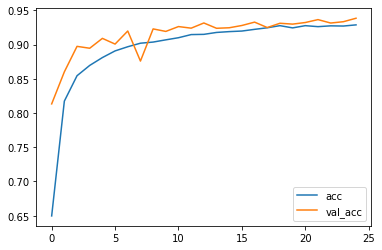

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.legend()

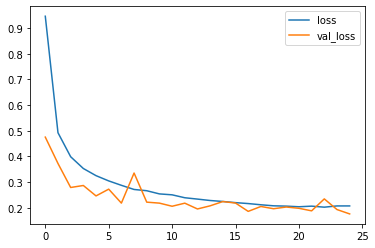

In [25]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

In [26]:
test_images = tf.image.resize(test_images,(150,150))

In [27]:
test_generator = ImageDataGenerator(
    rescale=1./255
)

test_generator.fit(test_images)

test_generator = test_generator.flow(
        test_images,
        test_labels,
        batch_size=200,)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9154000282287598


In [28]:
model = keras.models.load_model('best_weights.hdf5')

In [29]:
test_generator = ImageDataGenerator(
    rescale=1./255
)

test_generator.fit(test_images)

test_generator = test_generator.flow(
        test_images,
        test_labels,
        batch_size=200,)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.9154000282287598
